# Figure comparing weights, pressures and star formation rate surface densities for Figure 13 in Jeffreson et al. 2024b

In [1]:
import numpy as np
import h5py
from PRFMData import PRFMDataset
import astro_helper as ah

import pickle
from pathlib import Path
import glob, os, re, sys
import configparser
config = configparser.ConfigParser()
config.read('config_pressures-SFRs.ini')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

In [2]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          r"Milky Way-like",
          r"NGC~300-like",]
colors = [plt.cm.magma((i+1)/5) for i in range(4)]
colors.append('#3C3C3C')
colors.append('#5E9F87')

In [3]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW', 'NGC300']
Rmaxs_kpc = [config[tag].getfloat('RMAX') for tag in tags]
Rmaxs_kpc = [1.5 if elem==2. else elem for elem in Rmaxs_kpc] # cut to actual max size of ETGs

# Load the data

In [7]:
Rbin_centers, data_weights, data_PSFRs = [], [], []
for tag in tags:
    filesavedir = Path(config[tag]['ROOT_DIR']) / config[tag]['SUBDIR']

    # weight from this array (temperature threshold here has no impact)
    filesavename = min(glob.glob(str(filesavedir / "weights_*.pkl")))
    with open(filesavename, "rb") as f:
        props_3D = pickle.load(f)
    data_weights.append(props_3D)

    # pressures, counts and SFRs from this array (respond to temperature threshold)
    filesavename = min(glob.glob(str(filesavedir / "pressures-SFRs-fixed-mp_*_T2.0e+04_avir2.0e+00.pkl")))
    with open(filesavename, "rb") as f:
        props_3D = pickle.load(f)
    data_PSFRs.append(props_3D)
    
    # radial bin data from this array
    filesavename = min(glob.glob(str(filesavedir / "Rbin_centers_*.pkl")))
    with open(filesavename, "rb") as f:
        Rbins = pickle.load(f)
    Rbin_centers.append(Rbins)

In [8]:
# calculate medians and quantiles
THRESHOLD = 50 # on the number of gas cells per voxel at the mid-plane
# this is particularly important for the SigmaSFR, because SFR is stochastic in this simulation, and
# values do not make sense if averages/medians are taken over too few cells

meddata, q1data, q4data = [], [], []
meddata_PSFRs, q1data_PSFRs, q4data_PSFRs = [], [], []
for i, Rmax_kpc, data_, data_PSFRs_ in zip(range(len(data_weights)), Rmaxs_kpc, data_weights, data_PSFRs):
    
    # adjust the left-force and right-force to be absolute values
    data_['Force'] = np.fabs(data_['Force'])
    data_['ForceLeft'] = np.fabs(data_['ForceLeft'])
    data_['ForceRight'] = np.fabs(data_['ForceRight'])
    data_['ForceMin'] = np.minimum(data_['ForceLeft'], data_['ForceRight'])

    # take cuts to deal with stochasticity of the SFR, and to ensure the mid-plane
    # turbulent velocity dispersion is well-resolved
    cnd = (data_PSFRs_['midplane-count'] > THRESHOLD)
    for key, value in data_PSFRs_.items():
        value[~cnd] = np.nan
    for key, value in data_.items():
        if key == 'PtlMinIdcs':
            continue
        value[~cnd] = np.nan

    # apply radial cut to disk extent for the ETGs
    cnd = (Rbin_centers[i]/ah.kpc_to_cm < Rmax_kpc)
    Rbin_centers[i] = Rbin_centers[i][cnd]
    meddata.append({key: np.nanmedian(value, axis=(1,2))[cnd] for key, value in data_.items()})
    q1data.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] for key, value in data_.items()})
    q4data.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] for key, value in data_.items()})

    meddata_PSFRs.append({key: np.nanmedian(value, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})
    q1data_PSFRs.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})
    q4data_PSFRs.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})

# Now load pre-calculated contributions to the vertical potential, from each component of the galaxy (gas, disk, bulge, DM). Note that this is done by summing forces for all particles (Arepo does not record contributions to the potential). It's therefore only done for one snapshot and the code for doing this does not exist in this repo. It's just for show.

In [9]:
# from previous calculation (bin size not consistent but computation is just for show
# and is very slow for NGC300 and MW)
zbinnos = [60 for i in range(6)]
zbinmins = [-300., -300., -300., -300., -1500., -1500.] # pc
zbinmaxs = [300., 300., 300., 300., 1500., 1500.] # pc

zbinseps, zbin_centers = [], []
for i in range(6):
    zbin_edges = np.linspace(-300., 300., zbinnos[i]+1) * ah.pc_to_cm
    zbin_centers.append((zbin_edges[1:]+zbin_edges[:-1])/2.)
    zbinseps.append((zbinmaxs[i]-zbinmins[i])/zbinnos[i] * ah.pc_to_cm)

Rmins = [0.3 for i in range(6)]
Rmaxs = [1.5, 1.5, 1.5, 1.5, 13., 6.]
Rbinnos = [int(np.rint((Rmax-Rmin)/(0.2))) for Rmin, Rmax in zip(Rmins, Rmaxs)]

Rbin_centers_indiv = []
for i in range(6):
    Rbin_edges = np.linspace(Rmins[i], Rmaxs[i], Rbinnos[i]+1) * ah.kpc_to_cm
    Rbin_centers_indiv.append((Rbin_edges[1:]+Rbin_edges[:-1])/2.)

In [10]:
# fix snapshot number as we don't have all computed
ptl_snapnos = [400, 400, 399, 399, 300, 796]

In [11]:
for tag, ptl_snapno, i in zip(tags, ptl_snapnos, range(len(tags))):
    filesavedir = Path(config[tag]['ROOT_DIR']) / config[tag]['SUBDIR'] / 'saved-arrays'

    # last snapshot for which potential components were calculated
    rho3D_name = max(glob.glob(str(filesavedir / "rho3Ds_*.npy")))
    rho3D = np.load(rho3D_name, allow_pickle=True)

    medForceLeft_dict, medForceRight_dict = {}, {}

    ptl_names = ['ptl_', 'ptl1_', 'ptl2_', 'ptl3_']
    ptl_names = [ptl_name + str(ptl_snapno) + '.npy' for ptl_name in ptl_names]
    for ptl_name in ptl_names:
        try:
            ptl = np.load(max(glob.glob(str(filesavedir / ptl_name))), allow_pickle=True)
            ptl = np.swapaxes(ptl, 0,1)
        except ValueError:
            continue

        # get weight by same method as in PRFMData.py
        dz = np.gradient(np.tile(zbin_centers[i][np.newaxis,np.newaxis,:], (ptl.shape[0], ptl.shape[1], 1)), axis=2)
        dPhi = np.gradient(ptl, axis=2)
        dPhidz = dPhi/dz

        integrand = rho3D * dPhidz * zbinseps[i]
        z_mp_idcs = np.argmin(np.cumsum(integrand, axis=2), axis=2) # define mid-plane by potential minimum

        integrand_left = np.zeros_like(integrand)
        integrand_right = np.zeros_like(integrand)
        for j in range(ptl.shape[0]):
            for k in range(ptl.shape[1]):
                integrand_left[j,k,:z_mp_idcs[j,k]] = integrand[j,k,:z_mp_idcs[j,k]]
                integrand_right[j,k,z_mp_idcs[j,k]:] = integrand[j,k,z_mp_idcs[j,k]:]
        force_left = np.sum(integrand_left, axis=2)
        force_right = np.sum(integrand_right, axis=2)

        key = ptl_name.split('_')[0]
        medForceLeft_dict[key] = np.nanmedian(np.fabs(force_left), axis=1) / ah.kB_cgs
        medForceRight_dict[key] = np.nanmedian(np.fabs(force_right), axis=1) / ah.kB_cgs
    
    meddata[i]['ForceLeftIndiv'] = medForceLeft_dict
    meddata[i]['ForceRightIndiv'] = medForceRight_dict

# For the weight, select the time/cylindrical position-averaged 'side' of the force (left vs. right) that's the smallest. This provides the 'reaction' against the larger force from the other side, and so gives us the upper limit on the weight.

In [12]:
for meddata_, q1data_, q4data_ in zip(meddata, q1data, q4data):
    # pre-calculated components
    meddata_['WeightIndiv'] = {
        key: np.minimum(meddata_['ForceLeftIndiv'][key], meddata_['ForceRightIndiv'][key]) for
        key in meddata_['ForceLeftIndiv'].keys()
    }

    # everything else
    medweight_ = np.minimum(meddata_['ForceLeft'], meddata_['ForceRight'])

    min_from_left = meddata_['ForceLeft'] < meddata_['ForceRight']
    min_from_right = meddata_['ForceRight'] < meddata_['ForceLeft']
    indicator_array = np.where(min_from_left, 0, 1)

    q1weight_ = np.array([
        left if indicator==0 else right for
        left, right, indicator in zip(q1data_['ForceLeft'], q1data_['ForceRight'], indicator_array)
    ])
    q4weight_ = np.array([
        left if indicator==0 else right for
        left, right, indicator in zip(q4data_['ForceLeft'], q4data_['ForceRight'], indicator_array)
    ])

    meddata_['Weight'] = medweight_
    q1data_['Weight'] = q1weight_
    q4data_['Weight'] = q4weight_

# Final figure

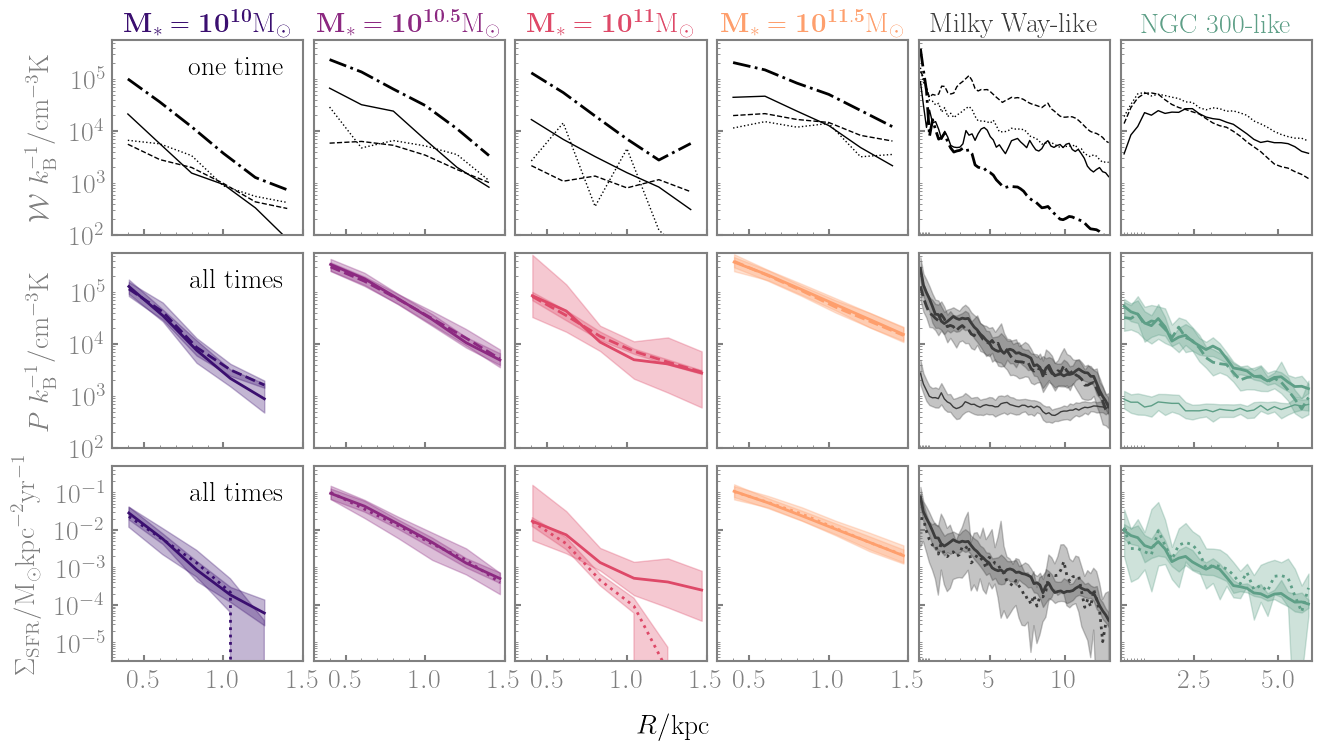

In [13]:
figW = 15
figH = 9
fig = plt.figure(figsize=(figW, figH))

botMarg = 0.11
topMarg = 0.2
leftMarg = 0.1
rightMarg = 0.1
hBetMarg = 0.02
wBetMarg = 0.007

crightMarg = 0.105
cW = 0.015
cBet = 0.002

h = (1.0-topMarg-botMarg-2.*hBetMarg)/3
w = (1.0-leftMarg-rightMarg-5.*wBetMarg)/6

### axes ###
axs_mid = []
for i, Rmax in zip(range(6), Rmaxs_kpc):
    if(i==0):
        ylabel=r'$P~k_{\rm B}^{-1}/{\rm cm}^{-3} {\rm K}$'
        ax = fig.add_axes([leftMarg+i*(w+wBetMarg), botMarg+(h+hBetMarg), w, h], ylim=[10.**2., 10.**5.75], xlim=[0.3, Rmax],
                         xlabel='', xticklabels='', ylabel=ylabel)
    else:
        ax = fig.add_axes([leftMarg+i*(w+wBetMarg), botMarg+(h+hBetMarg), w, h], ylim=[10.**2., 10.**5.75], xlim=[0.3, Rmax],
                         xlabel='', xticklabels='', yticklabels='')
    axs_mid.append(ax)

axs_bot = []
for i, Rmax in zip(range(6), Rmaxs_kpc):
    if(i==0):
        ylabel=r'$\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2} {\rm yr}^{-1}$'
        ax = fig.add_axes([leftMarg+i*(w+wBetMarg), botMarg, w, h], ylim=[10.**(-5.5), 0.5], xlim=[0.3, Rmax],
                         xlabel='', ylabel=ylabel)
    else:
        ax = fig.add_axes([leftMarg+i*(w+wBetMarg), botMarg, w, h], ylim=[10.**(-5.5), 0.5], xlim=[0.3, Rmax],
                         xlabel='', yticklabels='')
    axs_bot.append(ax)

axs_top = []
for i, Rmax in zip(range(6), Rmaxs_kpc):
    if(i==0):
        ylabel=r'$\mathcal{W}~k_{\rm B}^{-1}/{\rm cm}^{-3} {\rm K}$'
        ax = fig.add_axes([leftMarg+i*(w+wBetMarg), botMarg+2*(h+hBetMarg), w, h], ylim=[10.**2., 10.**5.75], xlim=[0.3, Rmax],
                         xlabel='', xticklabels='', ylabel=ylabel)
    else:
        ax = fig.add_axes([leftMarg+i*(w+wBetMarg), botMarg+2*(h+hBetMarg), w, h], ylim=[10.**2., 10.**5.75], xlim=[0.3, Rmax],
                         xlabel='', xticklabels='', yticklabels='')
    axs_top.append(ax)

for ax in axs_bot+axs_mid+axs_top:
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', direction='in', length=4)
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(0.1, 1.0, 0.1), numticks=10))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(0.1, 1.0, 0.1), numticks=10))
    ax.tick_params(axis='both', which='minor', direction='in', length=2)
    if ax not in [axs_bot[0], axs_mid[0], axs_top[0]]:
        ax.yaxis.set_tick_params(which='both', labelleft=False)

for ax, label, color in zip(axs_top, labels, colors):
    ax.set_title(label, color=color, fontsize=20)
fig.text(0.45, 0.03, r'$R/{\rm kpc}$')

### plot stuff
# weight vs. pressure
for ax, color, i in zip(axs_mid, colors, range(len(Rbin_centers))):
    ax.plot(Rbin_centers[i]/ah.kpc_to_cm, meddata[i]['Weight'], color=color, lw=2)
    ax.fill_between(Rbin_centers[i]/ah.kpc_to_cm, q1data[i]['Weight'],
                    y2=q4data[i]['Weight'], alpha=0.3, color=color)

    ax.plot(Rbin_centers[i]/ah.kpc_to_cm, meddata_PSFRs[i]['Ptot'], color=color, lw=2, ls='dashed')
    ax.fill_between(Rbin_centers[i]/ah.kpc_to_cm, q1data_PSFRs[i]['Ptot'], y2=q4data_PSFRs[i]['Ptot'], alpha=0.3, color=color)

    ax.plot(Rbin_centers[i]/ah.kpc_to_cm, meddata_PSFRs[i]['Ptherm'], color=color, lw=1)
    ax.fill_between(Rbin_centers[i]/ah.kpc_to_cm, q1data_PSFRs[i]['Ptherm'], y2=q4data_PSFRs[i]['Ptherm'], alpha=0.3, color=color)
    
# pressure vs. SFR
for ax, color, i in zip(axs_bot, colors, range(len(Rbin_centers))):
    
    # SFRs
    ax.plot(Rbin_centers[i] / ah.kpc_to_cm, meddata_PSFRs[i]['SigmaSFR'], color=color, lw=2, ls='dotted')
    ax.fill_between(Rbin_centers[i] / ah.kpc_to_cm, q1data_PSFRs[i]['SigmaSFR'], y2=q4data_PSFRs[i]['SigmaSFR'], alpha=0.3, color=color)

    # pressures via Equation 6 of Jeffreson et al. 2024b
    ax.plot(Rbin_centers[i] / ah.kpc_to_cm, 10.**(-7.86) * meddata[i]['Weight']**1.235,
            color=color, lw=2, label='total')
    ax.fill_between(Rbin_centers[i] / ah.kpc_to_cm,
                    10.**(-7.86) * q1data[i]['Weight']**1.235, y2=10.**(-7.86) * q4data[i]['Weight']**1.235,
                    alpha=0.3, color=color)

# weight contributions
linestyles = ['-', 'dotted', 'dashed', '-.']
linewidths = [1, 1, 1, 2]
weight_labels = ['gas', 'dark matter', 'disk', 'bulge']
for ax, i in zip(axs_top, range(len(Rbin_centers_indiv))):
    for key, ls, lw, weight_label in zip(meddata[i]['WeightIndiv'].keys(), linestyles, linewidths, weight_labels):
        if i==4:
            ax.plot(Rbin_centers_indiv[i]/ah.kpc_to_cm, meddata[i]['WeightIndiv'][key], ls=ls, lw=lw, color='k', label=weight_label)
        else:
            ax.plot(Rbin_centers_indiv[i]/ah.kpc_to_cm, meddata[i]['WeightIndiv'][key], ls=ls, lw=lw, color='k')

# annotations
axs_top[0].annotate("one time", xy=(0.9, 0.825), xycoords='axes fraction', ha='right')
axs_mid[0].annotate("all times", xy=(0.9, 0.825), xycoords='axes fraction', ha='right')
axs_bot[0].annotate("all times", xy=(0.9, 0.825), xycoords='axes fraction', ha='right')

#fig.subplots_adjust(top=10., bottom=0.1, left=0.1, right=0.9)

# legend, data
legend1 = axs_top[4].legend(
    loc='upper center', bbox_to_anchor=(-1., 1.85), ncol=4, frameon=False, handlelength=1.25, columnspacing=0.75,
)

custom_lines = [Line2D([0], [0], color='k', ls='dashed', lw=2),
                Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='k', ls='dotted', lw=2)]
legend2 = axs_top[4].legend(
    custom_lines, [r'ISM weight ($\mathcal{W}$)',
                   r'total pressure ($P_{\rm tot}$)',
                   r'thermal pressure ($P_{\rm th}$)',
                   r'SFR surface density ($\Sigma_{\rm SFR}$)'
                  ],
    loc='upper center', bbox_to_anchor=(-1., 1.6), ncol=4, frameon=False, handlelength=1, columnspacing=0.75,
)
axs_top[4].add_artist(legend1)
axs_top[4].add_artist(legend2)

# plt.savefig(
#     '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/rotcurves.pdf',
# #    bbox_inches='tight',
#     format='pdf'
# )

plt.show()